In [34]:
from __future__ import annotations
from IPython import get_ipython

from dataclasses import dataclass

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

import scipy.stats as stats

from typing import Optional, Any, Tuple
import numpy.typing as npt
from sklearn.metrics import auc

### Some functions

In [35]:
confidence = 0.95

def assign_random_variant(df, variant_col, random_seed=42, num_samples=None, replace=True):
    np.random.seed(random_seed)
    if num_samples:
        df = df.sample(num_samples, replace=replace)
    df[variant_col] = np.random.choice(['control', 'treatment'], size=df.shape[0], p=[0.5, 0.5])
    return df

def bootstrap_differences(df, variant_col, value_col, variant1="treatment", variant2="control", 
                          iterations=100, num_samples=None):
    means_s = []
    for i in range(iterations):
        df_random = assign_random_variant(df, variant_col, random_seed=i, num_samples=num_samples)
        this_mean = (df_random.loc[df_random[variant_col]==variant1][value_col].mean() - 
                       df_random.loc[df_random[variant_col]==variant2][value_col].mean())
        means_s.append(this_mean)
    means_s = pd.Series(means_s)
    return means_s

In [36]:
#Z and T tests

def z_test_mean_diff(df, variant_col, value_col, 
                     variant1="treatment", variant2="control", 
                     alpha=0.05, alternative='two-sided'):
    """
    Perform a two-sample z-test for the mean difference between two samples in a pandas DataFrame.

    Parameters:
    -----------
    df: pandas DataFrame
        The DataFrame containing the data.
    variant_col: str
        The name of the column containing the variant labels.
    value_col: str
        The name of the column containing the values to compare.
    variant1: str
        The label for the first variant.
    variant2: str
        The label for the second variant.
    alpha: float, optional
        The significance level. Default is 0.05.
    alternative: str, optional
        The alternative hypothesis. Possible values are 'two-sided', 'less' or 'greater'.
        Default is 'two-sided'.

    Returns:
    --------
    z_score: float
        The z-score.
    p_value: float
        The p-value.
    reject_null: bool
        Whether to reject the null hypothesis or not.
    """

    # Separate the two samples based on the variant column
    sample1 = df[df[variant_col] == variant1][value_col]
    sample2 = df[df[variant_col] == variant2][value_col]

    # Calculate the sample means and standard deviations
    mean1 = sample1.mean()
    mean2 = sample2.mean()
    std1 = sample1.std()
    std2 = sample2.std()

    # Calculate the pooled standard deviation
    try: 
        pooled_std = ((std1**2) / len(sample1) + (std2**2) / len(sample2))**0.5
    except ZeroDivisionError:
        pooled_std = 0
    # Calculate the z-score
    try: 
        z_score = (mean1 - mean2) / pooled_std
    except ZeroDivisionError:
        z_score = 0.5
    

    # Calculate the p-value
    if alternative == 'two-sided':
        p_value = stats.norm.sf(abs(z_score)) * 2
    elif alternative == 'less':
        p_value = stats.norm.cdf(z_score)
    elif alternative == 'greater':
        p_value = stats.norm.sf(z_score)
    else:
        raise ValueError("Invalid alternative hypothesis. Possible values are 'two-sided', 'less' or 'greater'.")

    # Determine whether to reject the null hypothesis
    reject_null = p_value < alpha

    return z_score, p_value, reject_null


def t_test_mean_diff(df, variant_col, value_col, variant1="treatment", variant2="control", 
                     alpha=0.05, alternative='two-sided'):
    """
    Performs a two-sample t-test for the mean difference between two variants.
    Inputs:
        - df: pandas DataFrame containing the data
        - variant_col: string, name of the column that indicates the variant ('control' or 'treatment')
        - value_col: string, name of the column containing the values to compare
    Returns:
        - tuple (t_statistic, p_value)
    """
    control_values = df[df[variant_col] == variant1][value_col]
    treatment_values = df[df[variant_col] == variant2][value_col]
    t_statistic, p_value = stats.ttest_ind(control_values, treatment_values, alternative=alternative)
    
    # Determine whether to reject the null hypothesis
    reject_null = p_value < alpha
    
    return t_statistic, p_value, reject_null

In [37]:

# Bootstrap tests: Percentile and Effron-Tibshirani

def get_frequency_tables(data, variant_col, value_col, count_col="user_id"):
    frequency_table = (data
                           .groupby([variant_col, value_col])[count_col]
                           .count()
                           .reset_index()
                           .rename(columns={count_col: "count"})
                      )
    variants = frequency_table["variant"].unique()
    variant_dict = {}
    for v in variants:
        variant_dict[v] = Variant(v, frequency_table.loc[frequency_table["variant"]==v])
        variant_dict[v].frequency_table = variant_dict[v].frequency_table.drop(columns="variant")
    
    return variant_dict

@dataclass
class Variant:
    tag: str
    frequency_table: pd.DataFrame

    def add_frequency_table(
        self,
        frequency: pd.DataFrame,
    ):
        self.frequency_table = frequency


def redraw(count: npt.NDArray[Any], n: int = 1_000) -> npt.NDArray[Any]:
    return np.random.multinomial(count.sum(), count / count.sum(), size=n)

def expected(x: npt.NDArray[Any], counts: npt.NDArray[Any]) -> npt.NDArray[Any]:
    return (counts * x).sum(axis=1) / counts.sum(axis=1)

@dataclass
class CountsTable:
    counts: npt.NDArray[Any]
    values: pd.DataFrame

    @classmethod
    def from_frequency(cls, freq: pd.DataFrame) -> CountsTable:
        return cls(np.array([freq["count"].values]), freq.drop("count", axis=1))

    def unbias(self) -> CountsTable:
        # Shift values by removing a constant so the first draw in the CountsTable has mean = 0
        if len(self.counts) > 1:
            raise RuntimeError("Can only unbias CountsTable with only one count")
        if len(self.values.values.T) > 1:
            raise RuntimeError("Can only unbias CountsTable with only one value")
        return CountsTable(
            self.counts, self.values - expected(self.values.values.T, self.counts)[0]
        )

    def redraw(self, n: int = 1) -> CountsTable:
        # Redraw `n` times from the first column of counts
        return CountsTable(redraw(self.counts[0], n), self.values)

decimal_places = lambda x: -int(math.floor(math.log10(abs(x)))) + 1
   
@dataclass
class ValueWithPercentile:
    mean: float
    low_perc: float
    high_perc: float

    def __str__(self):
        places = decimal_places(self.high_perc - self.low_perc)
        return (
            f"[{round(self.low_perc*100, places)} | {round(self.mean*100, places)} | "
            f"{round(self.high_perc*100, places)}]"
        )


@dataclass
class ValueWithCI:
    mean: float
    low_ci: float
    high_ci: float

    def __str__(self):
        places = decimal_places(self.high_ci - self.low_ci)
        return (
            f"[{round(self.low_ci, places)} | {round(self.mean, places)} | "
            f"{round(self.high_ci, places)}]"
        )
        
        
def t_statistic(count_a: CountsTable, count_b: CountsTable) -> Tuple[Any, Any, Any]:
    mean_a = expected(count_a.values.values.T, count_a.counts)
    mean_b = expected(count_b.values.values.T, count_b.counts)
    var_a = expected(count_a.values.values.T**2, count_a.counts) - mean_a**2
    var_b = expected(count_b.values.values.T**2, count_b.counts) - mean_b**2
    n_a = count_a.counts.sum(axis=1)
    n_b = count_b.counts.sum(axis=1)
    return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
        
    
def t_statistic_bootstrap(
    control_freq: pd.DataFrame,
    treatment_freq: pd.DataFrame,
    metric: str = "value",
    decimal_places: Optional[int] = None,
):
    control = CountsTable.from_frequency(control_freq)
    treatment = CountsTable.from_frequency(treatment_freq)
    stats_base = t_statistic(treatment, control)
    t_base = stats_base[0][0]
    m_base_t = stats_base[1][0]
    m_base_c = stats_base[2][0]
    c_redraw = control.unbias().redraw(1_000)
    t_redraw = treatment.unbias().redraw(1_000)
    stats_bootstrap = t_statistic(t_redraw, c_redraw)
    t_bootstrap = stats_bootstrap[0]
    m_bootstrap_t = stats_bootstrap[1]
    m_bootstrap_c = stats_bootstrap[2]
    return t_base, m_base_t, m_base_c, t_bootstrap, m_bootstrap_t, m_bootstrap_c

def bootstrap_mean(frequency):
    count = CountsTable.from_frequency(frequency)
    c_redraw = count.redraw(1_000)
    c_mean = c_redraw.counts @ c_redraw.values.values / sum(c_redraw.counts.T)[0]
    c_mean_df = pd.DataFrame(data=c_mean, columns=count.values.columns)
    return c_mean_df


def et_test(variants: dict[str, Variant], show_plots: bool = False, confidence: float = confidence, 
            alternative: str = "two-sided"):
    variant_a, variant_b = variants["control"], variants["treatment"]
    t_base, m_base_t, m_base_c, t_bootstrap, m_bootstrap_t, m_bootstrap_c = t_statistic_bootstrap(
        variant_a.frequency_table, variant_b.frequency_table
    )
    m_base = m_base_t - m_base_c
    resample_se_t = np.std(m_bootstrap_t)
    resample_se_c = np.std(m_bootstrap_c)
    resample_se = np.sqrt(resample_se_t**2 + resample_se_c**2)
    lower_q, upper_q = np.percentile(
        t_bootstrap, [(1 - confidence) / 2 * 100, (1 + confidence) / 2 * 100]
    )
    p_value_right = np.mean(t_bootstrap > t_base)
    p_value_left = np.mean(t_bootstrap < t_base)
    p_value_twosided = np.mean(abs(t_bootstrap) > abs(t_base))
    absolute_impact = ValueWithCI(
        m_base, m_base - resample_se * upper_q, m_base - resample_se * lower_q
    )
    resample_cv_t = resample_se_t / m_base_t
    resample_cv_c = resample_se_c / m_base_c
    rel_diff = (m_base_t - m_base_c) / abs(m_base_c)
    result = {
        "p_value_right":p_value_right,
        "p_value_left":p_value_left,
        "p_value_twosided":p_value_twosided,
    }
    # Calculate the p-value
    if alternative == 'two-sided':
        p_value = p_value_twosided
    elif alternative == 'less':
        p_value = p_value_left
    elif alternative == 'greater':
        p_value = p_value_right
    else:
        raise ValueError("Invalid alternative hypothesis. Possible values are 'two-sided', 'less' or 'greater'.")

    # Determine whether to reject the null hypothesis
    reject_null = p_value < 1-confidence

    return p_value, reject_null

def percentile_test(
    variants: dict[str, Variant], show_plots: bool = False, confidence: float = 0.95, alternative="two-sided"
):
    histogram = {}
    variant_a, variant_b = variants["control"], variants["treatment"]
    for variant in [variant_a, variant_b]:
        bootstrap = bootstrap_mean(variant.frequency_table)
        histogram[variant.tag] = bootstrap.iloc[:,0]

    p_value_right = np.mean(histogram[variant_a.tag] >= histogram[variant_b.tag], axis=0)
    p_value_left = np.mean(histogram[variant_b.tag] >= histogram[variant_a.tag], axis=0)
    p_value_twosided = np.mean(abs(histogram[variant_a.tag]) >= abs(histogram[variant_b.tag]), axis=0)
    result = {
        "p_value_right":p_value_right,
        "p_value_left":p_value_left,
    }
    
    # Calculate the p-value
    if alternative == 'two-sided':
        p_value = np.nan
    elif alternative == 'less':
        p_value = p_value_left
    elif alternative == 'greater':
        p_value = p_value_right
    else:
        raise ValueError("Invalid alternative hypothesis. Possible values are 'two-sided', 'less' or 'greater'.")

    # Determine whether to reject the null hypothesis
    reject_null = p_value < 1-confidence

    return p_value, reject_null

In [38]:
# Define the function to apply the z-test to multiple dataframes
def run_test_mean_diff_multiple(df, variant_col, value_col, number_of_tests=100, 
                                num_samples=None, alternative="two-sided", effect=0):
    # Initialize an empty DataFrame to store the results
    results_df = pd.DataFrame(columns=['test_number', 
                                       'z_score', 'z_p_value', 'z_reject_null',
                                       't_score', 't_p_value', 't_reject_null'])
    
    # Iterate over pairs of dataframes
    for i in range(number_of_tests):
        random_df = assign_random_variant(df, variant_col, random_seed=i, num_samples=num_samples)
        random_df[value_col] = np.where(random_df[variant_col]=="treatment", 
                                        random_df[value_col]*(1+effect), 
                                        random_df[value_col])
        # Apply the z-test to the pair of dataframes
        z_score, z_p_value, z_reject_null = z_test_mean_diff(random_df, variant_col=variant_col, alpha=1-confidence,
                                                             value_col=value_col, alternative=alternative)

        # Apply the t-test to the pair of dataframes
        t_score, t_p_value, t_reject_null = t_test_mean_diff(random_df, variant_col=variant_col, alpha=1-confidence,
                                                             value_col=value_col, alternative=alternative)
        
        
        # Apply the percentile bootstrap test to the pair of dataframes
        variant_dict = get_frequency_tables(random_df, variant_col="variant", value_col="total_sales")
        
        percentile_p_value, percentile_reject_null = percentile_test(variant_dict, alternative=alternative)
        et_p_value, et_reject_null = et_test(variant_dict, alternative=alternative)
        
        # Add the results to the DataFrame
        this_results = pd.DataFrame({'test_number': i,
                                        'z_score': z_score,
                                        'z_p_value': z_p_value,
                                        'z_reject_null': z_reject_null,
                                        't_score': t_score,
                                        't_p_value': t_p_value,
                                        't_reject_null': t_reject_null,
                                        'percentile_p_value': percentile_p_value,
                                        'percentile_reject_null': percentile_reject_null,
                                        'et_p_value': et_p_value,
                                        'et_reject_null': et_reject_null,},
                                   index=[0])
        results_df = pd.concat([results_df, this_results])
    
    # Return the results DataFrame
    return results_df

In [39]:
events_df = pd.read_csv("../Data/2019-Oct.csv")

In [40]:
events_df['time'] = pd.to_datetime(events_df['event_time'])
events_df['date'] = events_df['time'].dt.date
events_df["sales"] = np.where(events_df["event_type"]=="purchase", events_df["price"], 0)
events_df = pd.get_dummies(data=events_df, columns=["event_type"])
events_df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,time,date,sales,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view
0,2019-10-01 00:00:00 UTC,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:00+00:00,2019-10-01,0.0,True,False,False,False
1,2019-10-01 00:00:03 UTC,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:03+00:00,2019-10-01,0.0,True,False,False,False
2,2019-10-01 00:00:07 UTC,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:07+00:00,2019-10-01,0.0,True,False,False,False
3,2019-10-01 00:00:07 UTC,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:07+00:00,2019-10-01,0.0,True,False,False,False
4,2019-10-01 00:00:15 UTC,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:15+00:00,2019-10-01,0.0,True,False,False,False


In [41]:
# events_by_date = events_df.groupby("date").sum().reset_index()
# events_by_date.plot(x="date", y="sales", kind="line")

In [42]:
users_df = events_df.groupby("user_id").agg(
    {
        "user_id":                      ['size'],
        "sales":                        ['sum'],
        "event_type_view":              ["sum", "max"],
        "event_type_cart":              ["sum", "max"],
        "event_type_remove_from_cart":  ["sum", "max"],
        "event_type_purchase":          ["sum", "max"],
        "date":                         ["min", "max"]
    }
)
users_df.columns = ['_'.join(col).strip() for col in users_df.columns.values]
users_df = users_df.rename(columns={
    'user_id_size': 'num_events', 'sales_sum': 'total_sales', 
    'event_type_view_sum': 'total_views', 'event_type_view_max': 'has_view',
    'event_type_cart_sum': 'total_cart', 'event_type_cart_max': 'has_cart',
    'event_type_remove_from_cart_sum': 'total_remove_from_cart', 'event_type_remove_from_cart_max': 'has_remove_from_cart',
    'event_type_purchase_sum': 'total_purchases', 'event_type_purchase_max': 'has_purchases',
}).reset_index()
users_df[(users_df["has_purchases"]>=1) & (users_df["has_view"]==1)]#.columns
users_df = assign_random_variant(users_df, variant_col="variant")


<Axes: title={'center': 'Sales distribution'}, ylabel='Frequency'>

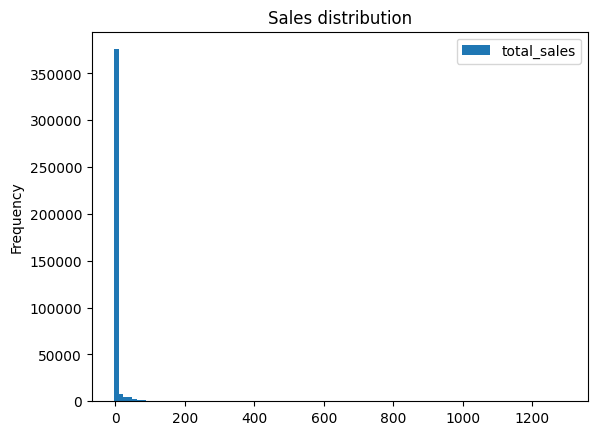

In [43]:
# Distribucion de ventas
users_df.plot.hist(y="total_sales", bins=100, title="Sales distribution")

<Axes: title={'center': 'Sales distribution (just paying users)'}, ylabel='Frequency'>

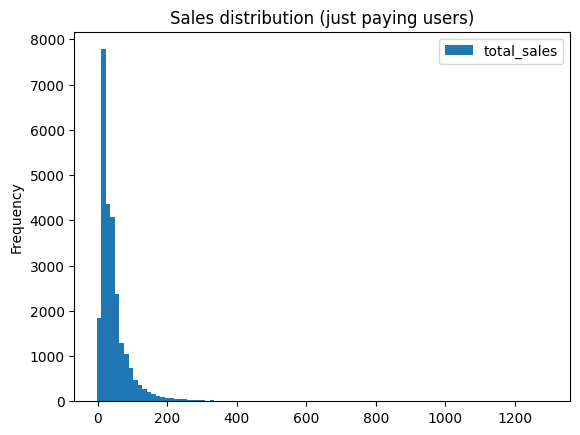

In [44]:
# Distribución de ventas para usuarios que compraron
users_df[users_df["total_sales"]!=0].plot.hist(y="total_sales", bins=100, title="Sales distribution (just paying users)")

In [45]:
users_df.describe()

,user_id,num_events,total_sales,total_views,total_cart,total_remove_from_cart,total_purchases
count,3.996640e+05,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000
mean,5.288604e+08,10.264330,3.031392,4.659324,3.083553,1.906877,0.614576
std,6.374482e+07,39.189611,18.257283,17.695189,12.649916,14.416924,3.711174
min,4.103071e+06,1.000000,-3.020000,0.000000,0.000000,0.000000,0.000000
25%,5.295908e+08,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,5.571228e+08,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,5.607882e+08,4.000000,0.000000,3.000000,3.000000,0.000000,0.000000
max,5.662808e+08,3965.000000,1295.480000,3086.000000,1129.000000,2783.000000,329.000000


In [46]:
users_df.loc[users_df["has_purchases"]==1].describe()

,user_id,num_events,total_sales,total_views,total_cart,total_remove_from_cart,total_purchases
count,2.576200e+04,25762.000000,25762.000000,25762.000000,25762.000000,25762.000000,25762.000000
mean,4.975684e+08,71.331690,47.028120,24.709728,21.134423,15.953187,9.534353
std,8.572289e+07,110.628724,55.697229,49.743400,32.672519,43.732120,11.341405
min,2.902578e+07,1.000000,-3.020000,0.000000,0.000000,0.000000,1.000000
25%,4.630881e+08,17.000000,16.490000,3.000000,5.000000,1.000000,3.000000
50%,5.372417e+08,38.000000,32.380000,10.000000,11.000000,4.000000,6.000000
75%,5.580677e+08,83.000000,54.947500,26.000000,25.000000,15.000000,12.000000
max,5.662742e+08,3965.000000,1295.480000,2124.000000,1107.000000,2783.000000,329.000000


## Normality

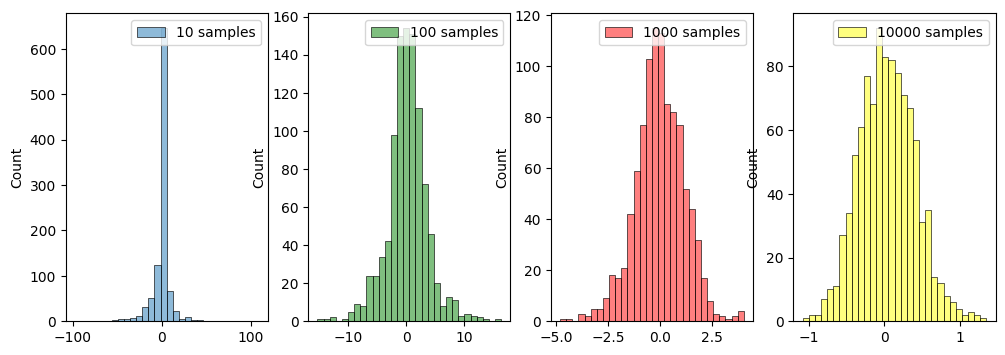

In [47]:
iterations = 1000
diffs_10 = bootstrap_differences(users_df, variant_col="variant", value_col="total_sales", 
                              iterations=iterations, num_samples=10)
diffs_100 = bootstrap_differences(users_df, variant_col="variant", value_col="total_sales", 
                              iterations=iterations, num_samples=100)
diffs_1000 = bootstrap_differences(users_df, variant_col="variant", value_col="total_sales", 
                              iterations=iterations, num_samples=1000)
diffs_10000 = bootstrap_differences(users_df, variant_col="variant", value_col="total_sales", 
                              iterations=iterations, num_samples=10000)

fig, ax = plt.subplots(1,4, figsize=(12, 4))
sns.histplot(diffs_10, bins=30, label=f"10 samples", ax=ax[0], alpha=0.5)
sns.histplot(diffs_100, bins=30, label=f"100 samples", ax=ax[1], color="green", alpha=0.5)
sns.histplot(diffs_1000, bins=30, label=f"1000 samples", ax=ax[2], color="red", alpha=0.5)
sns.histplot(diffs_10000, bins=30, label=f"10000 samples", ax=ax[3], color="yellow", alpha=0.5)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [48]:
# Test if the data follows a normal distribution
statistic, p_value = stats.normaltest(diffs_1000)

# Print the test statistic and p-value
print(f"Test statistic: {statistic}")
print(f"P-value: {p_value}")

Test statistic: 18.374015437378787
P-value: 0.00010236069891475584


In [49]:
# Test if the data follows a normal distribution
statistic, p_value = stats.shapiro(diffs_10000)

# Print the test statistic and p-value
print(f"Test statistic: {statistic}")
print(f"P-value: {p_value}")

Test statistic: 0.9971161484718323
P-value: 0.06925313174724579


In [50]:
# Test if the data follows a normal distribution
statistic, p_value = stats.kstest(diffs_1000, "norm")

# Print the test statistic and p-value
print(f"Test statistic: {statistic}")
print(f"P-value: {p_value}")

Test statistic: 0.03605765880166467
P-value: 0.14489311079894052


## AA

In [51]:
experiments = 1000
samples = 1000

p_values_AA = run_test_mean_diff_multiple(users_df, variant_col="variant", value_col="total_sales", 
                                          number_of_tests=experiments, num_samples=samples, alternative="greater")
p_values_AA = p_values_AA.reset_index(drop=True)
p_values_AA

,test_number,z_score,z_p_value,z_reject_null,t_score,t_p_value,t_reject_null,percentile_p_value,percentile_reject_null,et_p_value,et_reject_null
0,0,0.510265,0.304933,False,0.510221,0.305005,False,0.287,False,0.290,False
1,1,-0.515376,0.696855,False,-0.519557,0.698256,False,0.677,False,0.722,False
2,2,0.138669,0.444856,False,0.141290,0.443835,False,0.466,False,0.422,False
3,3,-1.586401,0.943676,False,-1.591698,0.944115,False,0.948,False,0.962,False
4,4,0.735179,0.231115,False,0.733541,0.231700,False,0.242,False,0.208,False
...,...,...,...,...,...,...,...,...,...,...,...
995,995,-1.315405,0.905813,False,-1.313053,0.905267,False,0.914,False,0.888,False
996,996,-1.150890,0.875111,False,-1.159232,0.876681,False,0.884,False,0.882,False
997,997,2.186930,0.014374,True,2.146610,0.016032,True,0.005,True,0.002,True
998,998,-1.015317,0.845023,False,-1.027319,0.847740,False,0.857,False,0.866,False


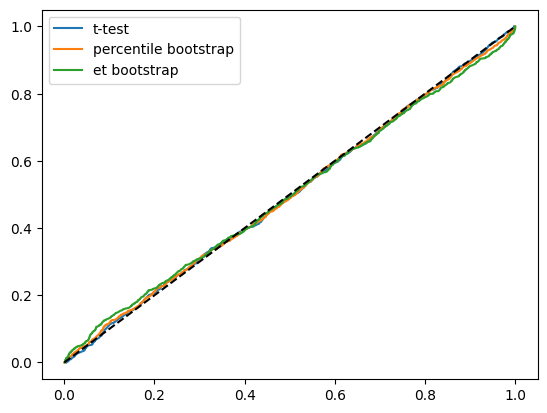

In [52]:
fig, ax = plt.subplots()
#ax.plot(sorted(p_values_AA["z_p_value"]), np.linspace(0, 1, experiments), label="z-test")
ax.plot(sorted(p_values_AA["t_p_value"]), np.linspace(0, 1, experiments), label="t-test")
ax.plot(sorted(p_values_AA["percentile_p_value"]), np.linspace(0, 1, experiments), label="percentile bootstrap")
ax.plot(sorted(p_values_AA["et_p_value"]), np.linspace(0, 1, experiments), label="et bootstrap")
ax.legend()
ax.plot([0,1],[0,1], '--k')

## AB

In [53]:
experiments = 1000
samples = 1000

p_values_AB = run_test_mean_diff_multiple(users_df, variant_col="variant", value_col="total_sales", 
                                          number_of_tests=experiments, num_samples=samples, alternative="greater",
                                         effect=2)
p_values_AB = p_values_AB.reset_index(drop=True)
p_values_AB

,test_number,z_score,z_p_value,z_reject_null,t_score,t_p_value,t_reject_null,percentile_p_value,percentile_reject_null,et_p_value,et_reject_null
0,0,3.438812,0.000292,True,3.422225,0.000323,True,0.000,True,0.000,True
1,1,2.593871,0.004745,True,2.585295,0.004935,True,0.003,True,0.001,True
2,2,1.520184,0.064232,False,1.564179,0.059046,False,0.013,True,0.013,True
3,3,1.332595,0.091332,False,1.326469,0.092494,False,0.095,False,0.071,False
4,4,3.134956,0.000859,True,3.112892,0.000953,True,0.000,True,0.001,True
...,...,...,...,...,...,...,...,...,...,...,...
995,995,1.497034,0.067192,False,1.544748,0.061362,False,0.052,False,0.027,True
996,996,1.915095,0.027740,True,1.894925,0.029196,True,0.023,True,0.016,True
997,997,3.508032,0.000226,True,3.415255,0.000331,True,0.000,True,0.000,True
998,998,2.112057,0.017341,True,2.086301,0.018602,True,0.017,True,0.007,True


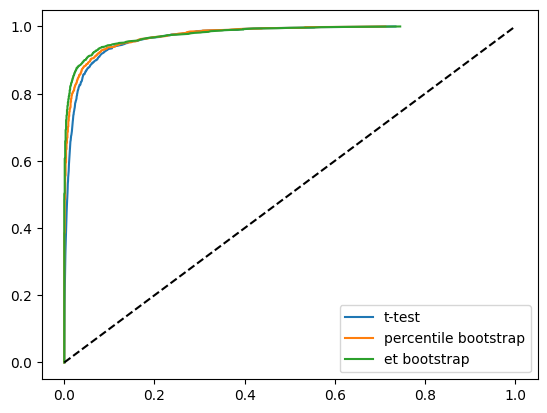

In [67]:
fig, ax = plt.subplots()
#ax.plot(sorted(p_values_AB["z_p_value"]), np.linspace(0, 1, experiments), label="z-test")
ax.plot(sorted(p_values_AB["t_p_value"]), np.linspace(0, 1, experiments), label="t-test")
ax.plot(sorted(p_values_AB["percentile_p_value"]), np.linspace(0, 1, experiments), label="percentile bootstrap")
ax.plot(sorted(p_values_AB["et_p_value"]), np.linspace(0, 1, experiments), label="et bootstrap")
ax.legend()
ax.plot([0,1],[0,1], '--k')

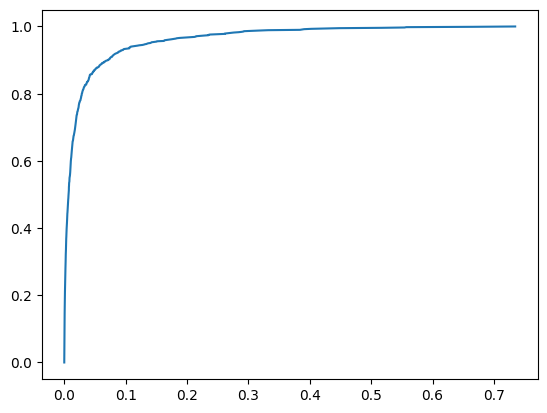

In [68]:
plt.plot(sorted(p_values_AB["t_p_value"]), np.linspace(0, 1, experiments))

In [71]:
for t in ["t_p_value", "z_p_value", "et_p_value", "percentile_p_value"]:
    auc_value = auc(sorted(p_values_AA[t]), np.linspace(0, 1, experiments))
    print(f"auc {t} AA: {auc_value}")

for t in ["t_p_value", "z_p_value", "et_p_value", "percentile_p_value"]:
    auc_value = auc(sorted(p_values_AB[t]), np.linspace(0, 1, experiments))
    print(f"auc {t} AB: {auc_value}")



auc t_p_value AA: 0.4957025626993491
auc z_p_value AA: 0.49606228406941133
auc et_p_value AA: 0.49939489489489486
auc percentile_p_value AA: 0.4983523523523524
auc t_p_value AB: 0.7061415914327264
auc z_p_value AB: 0.7011823563699301
auc et_p_value AB: 0.7242557557557556
auc percentile_p_value AB: 0.6886606606606606
